# Deep Learning - Programing Assignment 2
# Neural Networks
By Shu-Nong Wu | RIN: 661371234 | RCS: wus7
## 1. Introduction
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Programing assignment 1 dealt with logistic regression where the input layer of 785 nodes $X$ is multiplied by a weights and bias matrix $\theta$ and softmaxed to produce a predicted output $\hat{Y}$.
$$\hat{Y} = \sigma_m(\theta^TX)$$
However due to the fact that there is only 785x10 weights and biases the logistic regression model was only able to store a limited amount data for making predictions. In other words the **capacity** of the model was too small to support the complexity of the data. If the capacity is too small the model will underfit the data.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
To increase the capacity **hidden layers** must be added between the input and output layer of the logistic regression model turning into a **neural network**. Each layer is fully connected to the next layer thus adding more weights and biases. 
<img src="report_pictures/nn_model.png">
$$Source: Lecture$$
To get the value of nodes in the hidden layer $H^l$ the value of the previous layer $H^{l-1}$ must be multiplied by weights $W^l$ and added to the biases $W^l_0$. Finally this result must be passed through an activation function $\phi(x)$. For the first hidden layer $H^1$, $H^0$ is just $X$. The activation function will be explained later in this report.
$$H^l = \phi({W^l}^TH^{l-1}+W^l_0)$$
For the output layer the activation function that will be used is the softmax function. As mentioned earlier a neural network is able to support more weights and biases and is therefore able to create more complex higher order functions that map input to output. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In the first programing assignment the goal was to minimize the loss function by taking the gradient of the loss with respects to $\theta$, multiplying it by the learning rate, and subtracting it back to $\theta$.
$$ \theta^{t+1} = \theta^{t} - \eta\frac{\partial(L(D,\theta))}{\partial(\theta)}\Big|_{\theta=\theta^t} $$
This approach known as gradient descent will iteratively reduce the loss function thus making prediction more accurate. For neural networks, gradient descent is used to minimize loss by computing the gradient of all the weights, biases, and hidden node. $\nabla W^{L+1}, \nabla W_0^{L+1}, \nabla H^L$ are the gradients of the weights, biases of the output layer. $\nabla W^{l+1}, \nabla W_0^{l+1}, \nabla H^l$ are the gradients of the weights, biases of the hidden layers. These gradients are calculated, multiplied by the learning rate $\eta$, and subtracted to the weights and biases (but not the hidden layers). For every iteration, the weights and biases are changed such that they cause a small decrease in the loss.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Using a model that is too simple relative to the data causes under fitting. The other side of that coin is when too complex of a model is being used on data that is too simple. This results in over fitting when the model is conforms to the training data points too well but is not able to generalize to outside data sets. Because neural networks have more weights biases and therefore more complexity, it is subject to over fitting. There are two ways to mitigate this issue **regularization** and **dropout**. Regularization can be done by calculating the derivative of the L1 or L2 norm of the weights and biases, multiplying it by the regularization weighting $\nabla$ and adding it to its gradient. The final equation for updating weights and biases are
$$ W^l[t+1] = W^l[t] - \eta\bigg[\nabla{W^l}[t]+\lambda \frac{\partial{R(W^l[t])}}{\partial{W^l[t]}}\bigg] $$
$$ W^l_0[t+1] = W^l_0[t] - \eta\bigg[\nabla{W^l_0}[t]+\lambda \frac{\partial{R(W^l_0[t])}}{\partial{W^l_0[t]}}\bigg] $$
Dropout reduces the complexity of the model by randomly selecting hidden nodes with probability *p* and disabling the it along with it links. This is done every training iteration and results in a simpler model and avoid over fitting.
<img src="report_pictures/dropout.png">
$$Source: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf$$

#### Import Dependencies

In [3]:
%matplotlib notebook

import tensorflow as tf
import logging; logging.basicConfig(level=logging.DEBUG, filename='pa2.log')
import matplotlib.pyplot as plt
import pickle
import cv2
import numpy as np
# tf.set_random_seed(0)
# np.random.seed(0)

#### Define Constants

In [4]:
NUM_TRAINING_SAMPLES = 50000
NUM_TESTING_SAMPLES = 5000
NUM_CLASSES = 10
width, height = 28, 28

#### Define Helper Classes

In [5]:
class Data:
    """
    The mnist dataset built into Tensorflow allows you to conveniently call the
    next_batch() function to get the next batch of data.
    This is just a reimplementation of that function.
    """
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data
        self.batch_num = 0
        
    def next_batch(self, batch_size):
        """
        Used for gradient descent when the input data set is too large.
        You can split it up into batches of BATCH_SIZE and iterate through the batches.
        """
        X_batch = self.X_data[:,self.batch_num*batch_size:(self.batch_num+1)*batch_size]
        Y_batch = self.Y_data[:,self.batch_num*batch_size:(self.batch_num+1)*batch_size]
        self.batch_num += 1
        return X_batch, Y_batch
    
    def full_batch(self):
        """
        Returns a batch containing all data
        """
        return self.X_data, self.Y_data
    
    def random_batch(self, batch_size):
        """
        Used for stochastic gradient descent.
        Cuts the dataset into batches of BATCH_SIZE and randomly selects one of those batches
        """
        rand_nums = np.random.randint(self.X_data.shape[1], size=(batch_size))
        X_batch = self.X_data[:,rand_nums]
        Y_batch = self.Y_data[:,rand_nums]
        return X_batch, Y_batch

    
    def shuffle(self):
        """
        Shuffle the data between every epoch to have faster convergence
        """
        new_X = np.empty(self.X_data.shape, dtype=self.X_data.dtype)
        new_Y = np.empty(self.Y_data.shape, dtype=self.Y_data.dtype)
        perm = np.random.permutation(self.X_data.shape[1])
        for old_idx, new_idx in enumerate(perm):
            new_X[:,new_idx] = self.X_data[:,old_idx]
            new_Y[:,new_idx] = self.Y_data[:,old_idx]
        self.X_data = new_X
        self.Y_data = new_Y
        
    def reset(self, shuffle=False):
        self.batch_num = 0
        if shuffle:
            self.shuffle()

#### Define Helper Functions

In [6]:
def load_images_to_pickle():
    training_imgs = ['train_data/{:05d}.jpg'.format(i) for i in range(1, NUM_TRAINING_SAMPLES+1)]
    training_imgs = [cv2.imread(img, cv2.IMREAD_GRAYSCALE)/255 for img in training_imgs]
    training_imgs = np.array([img.reshape(width*height, 1) for img in training_imgs])
    training_imgs = np.squeeze(training_imgs, axis=2)
    training_imgs = training_imgs.T
    pickle.dump(training_imgs, open( "training_imgs.pickle", "wb" ))

    testing_imgs = ['test_data/{:05d}.jpg'.format(i) for i in range(1, NUM_TESTING_SAMPLES+1)]
    testing_imgs = [cv2.imread(img, cv2.IMREAD_GRAYSCALE)/255 for img in testing_imgs]
    testing_imgs = np.array([img.reshape(width*height, 1) for img in testing_imgs])
    testing_imgs = np.squeeze(testing_imgs, axis=2)
    testing_imgs = testing_imgs.T
    pickle.dump(testing_imgs, open( "testing_imgs.pickle", "wb" ))

def load_labels_to_pickle():
    with open('labels/train_label.txt', 'r') as labels:
        training_labels = labels.read().split('\n')[0:-1]
        training_labels = np.array([one_hot(int(training_label)) for training_label in training_labels])
        training_labels = np.squeeze(training_labels, axis=2)
        training_labels = training_labels.T
        pickle.dump(training_labels, open("training_labels.pickle", "wb" ))
        
    with open('labels/test_label.txt', 'r') as labels:
        testing_labels = labels.read().split('\n')[0:-1]
        testing_labels = np.array([one_hot(int(testing_label)) for testing_label in testing_labels])
        testing_labels = np.squeeze(testing_labels, axis=2)
        testing_labels = testing_labels.T
        pickle.dump(testing_labels, open("testing_labels.pickle", "wb" ))

def load_images_from_pickle():
    with open('training_imgs.pickle', 'rb') as handle:
        training_imgs = pickle.load(handle)
    with open('testing_imgs.pickle', 'rb') as handle:
        testing_imgs = pickle.load(handle)
    return training_imgs, testing_imgs
        
def load_labels_from_pickle():
    with open('training_labels.pickle', 'rb') as handle:
        training_labels = pickle.load(handle)
    with open('testing_labels.pickle', 'rb') as handle:
        testing_labels = pickle.load(handle)
    return training_labels, testing_labels

def one_hot(number):
    """
    Converts a number into its one_hot representation
    Eg: 4 -> [0,0,0,1,0,0,0,0,0,0]
        2 -> [0,1,0,0,0,0,0,0,0,0]
    This is done because the output of our model is represented as nodes.
    The activation of a node corresponds to some output.
    """
    ones = np.ones((1,1),dtype=np.float32)
    zeros = np.zeros((NUM_CLASSES-1,1), dtype=np.float32)
    return np.roll(np.concatenate([ones, zeros]),number)

def save_weights(theta, name):
    """
    Saves the weights and biases in pickle format
    theta = [w_1, w_1_0, w_2, w_2_0, w_3, w_3_0]
    """
    with open('{}.txt'.format(name), 'wb') as filehandler:
        pickle.dump(theta, filehandler, protocol=2)
        
def debug(sess, X_batch, Y_batch):
    """
    Dumps relevant data into a log file. This was super helpful for debugging
    because it allowed me to check my values and see if they looked correct
    """
    grad_Y_hat_value = sess.run(grad_Y_hat, feed_dict={X:X_batch, Y:Y_batch})
    grad_w_3_value = sess.run(grad_w_3, feed_dict={X:X_batch, Y:Y_batch})
    grad_w_3_0_value = sess.run(grad_w_3_0, feed_dict={X:X_batch, Y:Y_batch})
    grad_h_2_value = sess.run(grad_h_2, feed_dict={X:X_batch, Y:Y_batch})
    grad_w_2_value = sess.run(grad_w_2, feed_dict={X:X_batch, Y:Y_batch})
    grad_w_2_0_value = sess.run(grad_w_2_0, feed_dict={X:X_batch, Y:Y_batch})
    grad_h_1_value = sess.run(grad_h_1, feed_dict={X:X_batch, Y:Y_batch})
    grad_w_1_value = sess.run(grad_w_1, feed_dict={X:X_batch, Y:Y_batch})
    grad_w_1_0_value = sess.run(grad_w_1_0, feed_dict={X:X_batch, Y:Y_batch})
    w_1_value = sess.run(w_1, feed_dict={X:X_batch, Y:Y_batch})
    Y_hat_value = sess.run(Y_hat, feed_dict={X:X_batch, Y:Y_batch})
    w_3_value = sess.run(w_3, feed_dict={X:X_batch, Y:Y_batch})
    w_3_0_value = sess.run(w_3_0, feed_dict={X:X_batch, Y:Y_batch})
    h_2_value = sess.run(h_2, feed_dict={X:X_batch, Y:Y_batch})
    w_2_value = sess.run(w_2, feed_dict={X:X_batch, Y:Y_batch})
    w_2_0_value = sess.run(w_2_0, feed_dict={X:X_batch, Y:Y_batch})
    h_1_value = sess.run(h_1, feed_dict={X:X_batch, Y:Y_batch})
    w_1_0_value = sess.run(w_1_0, feed_dict={X:X_batch, Y:Y_batch})
    logging.debug('grad_Y_hat_value: {}\n'.format(grad_Y_hat_value))
    logging.debug('grad_w_3_value: {}\n'.format(grad_w_3_value))
    logging.debug('grad_w_3_0_value: {}\n'.format(grad_w_3_0_value))
    logging.debug('grad_h_2_value: {}\n'.format(grad_h_2_value))
    logging.debug('grad_w_2_value: {}\n'.format(grad_w_2_value))
    logging.debug('grad_w_2_0_value: {}\n'.format(grad_w_2_0_value))
    logging.debug('grad_h_1_value: {}\n'.format(grad_h_1_value))
    logging.debug('grad_w_1_value: {}\n'.format(grad_w_1_value))
    logging.debug('grad_w_1_0_value: {}\n'.format(grad_w_1_0_value))
    logging.debug('Y_hat_value: {}\n'.format(Y_hat_value))
    logging.debug('w_3_value: {}\n'.format(w_3_value)) 
    logging.debug('w_3_0_value: {}\n'.format(w_3_0_value))
    logging.debug('h_2_value: {}\n'.format(h_2_value))
    logging.debug('w_2_value: {}\n'.format(w_2_value)) 
    logging.debug('w_2_0_value: {}\n'.format(w_2_0_value))
    logging.debug('h_1_value: {}\n'.format(h_1_value))
    logging.debug('w_1_value: {}\n'.format(w_1_value)) 
    logging.debug('w_1_0_value: {}\n\n\n\n\n'.format(w_1_0_value))

#### Load Data

In [7]:
# load_images_to_pickle()
# load_labels_to_pickle()
training_imgs, testing_imgs = load_images_from_pickle()
training_labels, testing_labels = load_labels_from_pickle()
training_data = Data(training_imgs, training_labels)
testing_data = Data(testing_imgs, testing_labels)

## 2. Theory
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
To implement a neural network one needs to define hyper parameters, initialize weights and biases, define the neural network architecture, calculate the gradients of all the weights and biases, and updating the weights and biases.
### 2.1. Hyper Parameters
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Much like logistic regression, neural networks need well-tuned hyper parameters in order to converge quickly and accurately. Learning rate is multiplied to the gradients before they are subtracted to the weights and biases. Changing the learning rate will affect how big of a leap the weights and biases move towards its optimal values. If it is too small then it will take a long time to converge if it is too large then the weights and biases will overshoot it optimal value. $\lambda$ will affect the how dominant the regularization term will be. Number of epoch is referring to how many stochastic gradient descent iterations the model will be trained through. Batch size refers to how much data is being feed into the model in one iteration of training. Finally the number of nodes in the hidden layers must be specified. Increasing the number of nodes increases the capacity of the model but also increases the complexity and computational cost to run the model.

In [8]:
# Hyperparameters - Old
LEARNING_RATE = .25
LAMBDA = .0001
NUM_EPOCHS = 3000
BATCH_SIZE = 50
# Hyperparameters - New
L1_NODES = 100
L2_NODES = 100

### 2.2. Initalize Weights and Biases
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Between every two layers in the sequence of layer there need to be a set of weights and biases. In this case because there are 4 layers total there needs to be 3 sets of weights and biases. The weights are initalized randomly and the biases start at zero.

In [9]:
w_1   = tf.Variable(tf.scalar_mul(.1, tf.random_normal([width*height, L1_NODES])), name='weights_1')
w_1_0 = tf.Variable(tf.zeros([L1_NODES, 1]), name='biases_1')
w_2   = tf.Variable(tf.scalar_mul(.1, tf.random_normal([L1_NODES, L2_NODES])), name='weights_2')
w_2_0 = tf.Variable(tf.zeros([L2_NODES, 1]), name='biases_2')
w_3   = tf.Variable(tf.scalar_mul(.1, tf.random_normal([L2_NODES, NUM_CLASSES])), name='weights_3')
w_3_0 = tf.Variable(tf.zeros([NUM_CLASSES, 1]), name='biases_3')

### 2.3. Define Model
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Each hidden layer is calculated using the weights, biases, and nodes of the previous layer. Starting with the input layer, the layer is multiplied by the first weights and added to the bias. The results in then passed through an **activation function** which will introduce some nonlinearity to the model. This non linearity is beneficial because without it the model will behave like a single layer perceptron no matter how the model created. The activation function used for the hidden layers is **ReLu** and softmax is used in the output layer.
$$
\begin{equation} 
\begin{split}
H^1 & = ReLu({W^1}^TX+W^1_0) \\
H^2 & = ReLu({W^2}^TH^1+W^2_0) \\
\hat{Y} & = \sigma_m({W^3}^TH^2+W^3_0) \\
ReLu(x) & = max(0, x) 
\end{split}
\end{equation}
$$
There exists other activation function such as sigmoid, tanh, and leaky ReLu 
$$
\begin{equation} 
\begin{split}
\sigma(x) & =\frac{1}{1+e^{-x}} \\
tanh(x) & =\frac{e^x-e^{-x}}{e^x+e^{-x}} \\
LeReLu(x) & =\bigg\{
\begin{matrix}
\begin{split}
&{x\ if\ x>0} \\ 
&{ax\ otherwise,\ a=small\ constant}
\end{split}
\end{matrix}
\end{split}
\end{equation}
$$

In [11]:
X = tf.placeholder(dtype=tf.float32, shape=[width*height, None], name='images')
Y = tf.placeholder(dtype=tf.float32, shape=[NUM_CLASSES, None], name='labels')
h_1 = tf.matmul(w_1, X, transpose_a=True)
h_1 = tf.add(h_1, w_1_0)
h_1 = tf.nn.relu(h_1, name='layer_1')
h_2 = tf.matmul(w_2, h_1, transpose_a=True)
h_2 = tf.add(h_2, w_2_0)
h_2 = tf.nn.relu(h_2, name='layer_2')
Y_hat = tf.matmul(w_3, h_2, transpose_a=True)
Y_hat = tf.add(Y_hat, w_3_0)
Y_hat = tf.nn.softmax(Y_hat, dim=0, name='predicted')
Y_hat

<tf.Tensor 'predicted_1:0' shape=(10, ?) dtype=float32>

### 2.4. Define Loss Function
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The loss function used in this assignment is mean square error (MSE). MSE is calculated by taking the subtracting the predicted output with the actual output, squaring it elementwise, taking the sum across all output classes and averaging across all the sample.
$$l_{MSE} = \frac{1}{2M} \sum\limits_{m=1}^{M} \sum\limits_{k=1}^{K} \big(\hat{Y}[m][k]-Y[m][k]\big)^2$$

In [9]:
loss = tf.subtract(Y, Y_hat)
loss = tf.multiply(loss, loss)
loss = tf.scalar_mul(.5, loss)
loss = tf.reduce_sum(loss, axis=0)
loss = tf.reduce_mean(loss, axis=0)

### 2.5. Compute Gradients
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
All the weights, biases and nodes are connected to the output layer which is related to the loss. Therefore if any of those values gets changed it will cause a change in the loss. The idea for back propagation is to find out how much of a change in weights and biases will result in how much of a change in the loss. This value is known as the gradient and is the key to performing **gradient descent**. Once these gradients are calculated they are subtracted to the original weights and biases in order to get the loss to descent. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The process of computing these gradients is to use a tool called the **chain rule**. 
$$\frac{\partial f(g(x))}{\partial x} = f'(g(x))g'(x)$$
Because the neural network and the loss function is a complex function of functions one can take the derivative of a variable (weights, biases, and nodes) by taking the gradient of the output layer $\nabla\hat{Y}$ to calculate the gradients of the weights$\nabla W^{L+1}$, biases$\nabla W_0^{L+1}$, and nodes$\nabla H^L$ connected to the output layer. Then the gradients of the weights$\nabla W^l$, biases$\nabla W_0^l$, and nodes$\nabla H^{l-1}$ connected to hidden layers can be calculated using the gradient of the higher level layer$\nabla H^{l}$. This is done until the gradient decent algorithm hits the first input layer.
#### 2.5.1. Gradient of Output Layer
$$
\begin{equation}
\begin{split}
\nabla\hat{Y} & = \frac{1}{2}\frac{\partial(Y-\hat{Y})^t(Y-\hat{Y})}{\partial\hat{Y}} \\
& = \hat{Y}-Y
\end{split}
\end{equation}
$$

In [10]:
def grad_output_layer(Y_hat, Y):
    return tf.subtract(Y_hat, Y)

#### 2.5.2. Gradient of Weights (Output Layer)
$$
\begin{equation}
\begin{split}
\nabla W^{L+1} & = \frac{\partial\hat{Y}}{\partial W^{L+1}}\nabla\hat{Y} \\
& = \frac{\partial\sigma_m(z)}{\partial W^{L+1}}\nabla\hat{Y} \\
& = \sum^K_{i=1} \frac{\partial\sigma_m(z[i])}{\partial W^{L+1}} \partial\hat{Y}[i] \\
& = \sum^K_{i=1} 
\bigg[
\frac{\partial\sigma_m(z[i])}{\partial W^{L+1}[1]}\ 
\frac{\partial\sigma_m(z[i])}{\partial W^{L+1}[2]}\ ...
\frac{\partial\sigma_m(z[i])}{\partial W^{L+1}[K]}
\bigg]
\nabla\hat{Y}[i] \\
where\ \frac{\partial\sigma_m(z[i])}{\partial W^{L+1}[k]} & = 
\bigg\{
\begin{matrix}
\begin{split}
&{\sigma_m(z[k])(1-\sigma_m(z[k]))H^L\ \ \  if\ i=k} \\
&{-\sigma_m(z[k])\sigma_m(z[i]))H^L \quad\quad else}
\end{split}
\end{matrix}
\end{split}
\end{equation}
$$

In [11]:
def grad_w_output_layer(Y_hat, L_last, grad_Y_hat):
    Y_hat_split = tf.split(Y_hat, NUM_CLASSES)

    def grad_w_i_iequalk(k):
        Y_hat_k = tf.tile(Y_hat_split[k], [int(L_last.shape[0]), 1])
        one_minus_Y_hat_k = tf.subtract(tf.ones([L_last.shape[0], BATCH_SIZE]), Y_hat_k)
        gradient = tf.multiply(Y_hat_k, L_last)
        gradient = tf.multiply(gradient, one_minus_Y_hat_k)
        return gradient

    def grad_w_i_inotk(k, i):
        Y_hat_k = tf.tile(Y_hat_split[k], [int(L_last.shape[0]), 1])
        Y_hat_i = tf.tile(Y_hat_split[i], [int(L_last.shape[0]), 1])
        gradient = tf.multiply(Y_hat_k, Y_hat_i)
        gradient = tf.multiply(gradient, L_last)
        gradient = tf.negative(gradient)
        return gradient

    grad_w = []
    for k in range(NUM_CLASSES):    
        grad_w_k = []
        for i in range(NUM_CLASSES):
            if i == k:
                grad_w_k.append(grad_w_i_iequalk(k))
            else:
                grad_w_k.append(grad_w_i_inotk(k, i))
        grad_w_k = [tf.expand_dims(grad_w_k_i, 1) for grad_w_k_i in grad_w_k]
        grad_w_k = tf.concat(grad_w_k, axis=1)
        grad_w.append(grad_w_k)
    grad_w = [tf.expand_dims(grad_w_k, 1) for grad_w_k in grad_w]
    grad_w = tf.concat(grad_w, axis=1)  
    
    # grad_w must finally be multiplied by grad_Y_hat. But in order to do this we must
    # tile (or copy across different dimensions) grad_Y_hat matrix so it is the same dimensions
    # as the grad_w matrix
    grad_Y_hat = tf.tile(tf.expand_dims(grad_Y_hat, 1), [1, NUM_CLASSES, 1])
    grad_Y_hat = tf.tile(tf.expand_dims(grad_Y_hat, 0), [int(L_last.shape[0]), 1, 1, 1])
    grad_w = tf.multiply(grad_w, grad_Y_hat)
    grad_w = tf.reduce_mean(grad_w, axis=3)
    grad_w = tf.reduce_sum(grad_w, axis=1)
    
    return grad_w

#### 2.5.3. Gradient of Biases (Output Layer)
$$
\begin{equation}
\begin{split}
\nabla W_0^{L+1} & =\frac{\partial\hat{Y}}{\partial W_0^{L+1}}\nabla\hat{Y} \\
& = \frac{\partial\sigma_m(z)}{\partial W_0^{L+1}}\nabla\hat{Y} \\
& = \sum^K_{i=1} \frac{\partial\sigma_m(z[i])}{\partial W_0^{L+1}} \partial\hat{Y}[i] \\
& = \sum^K_{i=1} 
\bigg[
\frac{\partial\sigma_m(z[i])}{\partial W^{L+1}_0[1]}\ 
\frac{\partial\sigma_m(z[i])}{\partial W^{L+1}_0[2]}\ ...
\frac{\partial\sigma_m(z[i])}{\partial W^{L+1}_0[K]}
\bigg]^t
\nabla\hat{Y}[i] \\
where\ \frac{\partial\sigma_m(z[i])}{\partial W^{L+1}_0[k]} & = 
\bigg\{
\begin{matrix}
\begin{split}
&{\sigma_m(z[k])(1-\sigma_m(z[k]))\ \ \  if\ i=k} \\
&{-\sigma_m(z[k])\sigma_m(z[i]))\quad\quad else}
\end{split}
\end{matrix}
\end{split}
\end{equation}
$$

In [12]:
def grad_w_0_output_layer(Y_hat, grad_Y_hat):
    Y_hat_split = tf.split(Y_hat, NUM_CLASSES)
    
    def grad_w_0_i_iequalk(k):
        Y_hat_k = Y_hat_split[k]
        one_minus_Y_hat_k = tf.subtract(tf.ones([1, BATCH_SIZE]), Y_hat_k)
        gradient = tf.multiply(Y_hat_k, one_minus_Y_hat_k)
        return gradient

    def grad_w_0_i_inotk(k, i):
        Y_hat_k = Y_hat_split[k]
        Y_hat_i = Y_hat_split[i]
        gradient = tf.multiply(Y_hat_k, Y_hat_i)
        gradient = tf.negative(gradient)
        return gradient
    
    grad_w_0 = []
    for k in range(NUM_CLASSES):    
        grad_w_0_k = []
        for i in range(NUM_CLASSES):
            if i == k:
                grad_w_0_k.append(grad_w_0_i_iequalk(k))
            else:
                grad_w_0_k.append(grad_w_0_i_inotk(k, i))
        grad_w_0_k = tf.concat(grad_w_0_k, axis=0)
        grad_w_0.append(grad_w_0_k)
    grad_w_0 = [tf.expand_dims(grad_w_0_k, 0) for grad_w_0_k in grad_w_0]
    grad_w_0 = tf.concat(grad_w_0, axis=0)  
    
    # grad_w_0 must finally be multiplied by grad_Y_hat. But in order to do this we must
    # tile (or copy across different dimensions) grad_Y_hat matrix so it is the same dimensions
    # as the grad_w_0 matrix
    grad_Y_hat = tf.tile(tf.expand_dims(grad_Y_hat, 1), [1, NUM_CLASSES, 1])
    grad_w_0 = tf.multiply(grad_w_0, grad_Y_hat)
    grad_w_0 = tf.reduce_mean(grad_w_0, axis=2)
    grad_w_0 = tf.reduce_sum(grad_w_0, axis=0)
    grad_w_0 = tf.expand_dims(grad_w_0, axis=1)

    return grad_w_0

#### 2.5.4. Gradient of Hidden Layer (Output Layer)
$$
\begin{equation}
\begin{split}
\nabla H^L & = \frac{\partial\hat{Y}}{\partial H^L}\nabla\hat{Y} \\
& = \frac{\partial\sigma_m(z)}{\partial H^L}\nabla\hat{Y} \\
& = \sum^K_{i=1} \frac{\partial\sigma_m(z[i])}{\partial H^L} \nabla\hat{Y}[i] \\
where\ \frac{\partial\sigma_m(z[i])}{\partial H^L} & = 
\sigma_m(z[i])\bigg[W^{L+1}[i]-\sum^K_{j=1}\sigma_m(z[j])W^{L+1}_j)\bigg]
\end{split}
\end{equation}
$$

In [13]:
def grad_h_output_layer(Y_hat, w_last, grad_Y_hat):
    # Weights expanded such that the dimentions match Y_hat 
    Y_hat = tf.tile(tf.expand_dims(Y_hat, 0), [int(w_last.shape[0]), 1, 1])
    
    # Y_hat expanded such that it can be multiplied with w_last and sum_across_j
    w_last = tf.tile(tf.expand_dims(w_last, 2), [1, 1, BATCH_SIZE])
    
    # grad_Y_hat expanded such that it can be multiplied with Y_hat*(w_last - sum_across_j)
    grad_Y_hat = tf.tile(tf.expand_dims(grad_Y_hat, 0), [int(w_last.shape[0]), 1, 1])
    
    # Handles the part of the summation across all j's to big K.
    # Dimension are then expanded to match Y_hat
    sum_across_j = tf.reduce_sum(tf.multiply(Y_hat, w_last), axis=1)
    sum_across_j = tf.tile(tf.expand_dims(sum_across_j, 1), [1, NUM_CLASSES, 1])
        
    # Multiply out all these tensors together to get the gradient of H and reduce it
    grad_h = tf.subtract(w_last, sum_across_j)
    grad_h = tf.multiply(Y_hat, grad_h)
    grad_h = tf.multiply(grad_Y_hat, grad_h)
    grad_h = tf.reduce_sum(grad_h, axis=1)
    return grad_h

#### 2.5.5. Gradient of Weights (Hidden Layer)
$$
\begin{equation}
\begin{split}
\nabla W^l & = \frac{\partial H^l}{\partial W^l}\nabla H^l \\
& = \frac{\partial\phi(z)}{\partial W^l}\nabla H^l \\
& = \sum^{N_l}_{i=1} \frac{\partial\phi(z[i])}{\partial W^l} \nabla H^l[i] \\
& = \sum^{N_l}_{i=1} 
\bigg[
\frac{\partial\phi(z[i])}{\partial W^l[1]}\ 
\frac{\partial\phi(z[i])}{\partial W^l[2]}\ ...
\frac{\partial\phi(z[i])}{\partial W^l[N_l]}
\bigg]
\nabla{H^l}[i] \\
For\ ReLu\ \frac{\partial\phi(z[i])}{\partial W^l[k]} & = 
\bigg\{
\begin{matrix}
\begin{split}
&{H^{l-1}\ \ \  if\ i=k\ and\ z[i]>0} \\
&{0 \quad\quad else}
\end{split}
\end{matrix}
\end{split}
\end{equation}
$$

In [14]:
def grad_w_hidden_layer(h_l_min1, h_l, grad_h_l):
    d_phi_k_d_w_i = [h_l_min1 for _ in range(grad_h_l.shape[0])]
    d_phi_k_d_w_i = [tf.expand_dims(i, 1) for i in d_phi_k_d_w_i]
    d_phi_k_d_w_i = tf.concat(d_phi_k_d_w_i, axis=1)
    
    # We need to apply a boolean mask to the gradient because if z[m][i] <= 0
    # d_phi_k_d_w_i becomes zeros
    z_m_i_mask = tf.greater(h_l, 0)
    z_m_i_mask = tf.cast(z_m_i_mask, dtype=tf.float32)
    z_m_i_mask = tf.expand_dims(z_m_i_mask, 0)
    z_m_i_mask = tf.tile(z_m_i_mask, [int(h_l_min1.shape[0]), 1, 1])

    grad_h_l = tf.expand_dims(grad_h_l, 0)
    grad_h_l = tf.tile(grad_h_l, [int(h_l_min1.shape[0]), 1, 1])

    grad_w = tf.multiply(d_phi_k_d_w_i, z_m_i_mask)
    grad_w = tf.multiply(grad_h_l, grad_w)
    grad_w = tf.reduce_mean(grad_w, axis=2)
    
    return grad_w

#### 2.5.6. Gradient of Biases (Hidden Layer)
$$
\begin{equation}
\begin{split}
\nabla W_0^l & =\frac{\partial H^l}{\partial W_0^l}\nabla H^l \\
& = \frac{\partial\phi(z)}{\partial W_0^l}\nabla H^l \\
& = \sum^{N_l}_{i=1} \frac{\partial\phi(z[i])}{\partial W_0^l} \nabla H^l[i] \\
& = \sum^{N_l}_{i=1} 
\bigg[
\frac{\partial\phi(z[i])}{\partial W^l_0[1]}\ 
\frac{\partial\phi(z[i])}{\partial W^l_0[2]}\ ...
\frac{\partial\phi(z[i])}{\partial W^l_0[N_l]}
\bigg]^t
\nabla H^l[i] \\
For\ ReLu\ \frac{\partial\phi(z[i])}{\partial W^l_0[k]} & = 
\bigg\{
\begin{matrix}
\begin{split}
&{1 \quad if\ i=k} \\
&{0 \quad else}
\end{split}
\end{matrix}
\end{split}
\end{equation}
$$

In [15]:
def grad_w_0_hidden_layer(h_l, grad_h_l):
    z_m_i_mask = tf.greater(h_l, 0)
    z_m_i_mask = tf.cast(z_m_i_mask, dtype=tf.float32)
    
    grad_w_0 = tf.multiply(z_m_i_mask, grad_h_l)
    grad_w_0 = tf.reduce_mean(grad_w_0, axis=1)
    grad_w_0 = tf.expand_dims(grad_w_0, axis=1)
    
    return grad_w_0

#### 2.5.7. Gradient of Hidden Layer (Hidden Layer)
$$
\begin{equation}
\begin{split}
\nabla H^{l-1} & = \frac{\partial\phi(z)}{\partial H^{l-1}}\nabla H^l \\
& = \frac{\partial\phi(z)}{\partial H^{l-1}}\nabla H^l \\
& = \sum^{N_l}_{i=1} \frac{\partial\phi(z[i])}{\partial H^{l-1}} \nabla H^l[i] \\
For\ ReLu\ \frac{\partial\phi(z[i])}{\partial H^{l-1}} & = 
\bigg\{
\begin{matrix}
\begin{split}
&{W^l[i] \quad\quad if\ i=k\ and\ z[i]>0} \\
&{0 \quad\quad\quad\ \  else}
\end{split}
\end{matrix}
\end{split}
\end{equation}
$$

In [16]:
def grad_h_hidden_layer(w_l, h_l, grad_h_l):
    w_l = tf.expand_dims(w_l, 2)
    w_l = tf.tile(w_l, [1, 1, BATCH_SIZE])
    
    z_m_i_mask = tf.greater(h_l, 0)
    z_m_i_mask = tf.cast(z_m_i_mask, dtype=tf.float32)
    z_m_i_mask = tf.expand_dims(z_m_i_mask, 0)
    z_m_i_mask = tf.tile(z_m_i_mask, [int(w_l.shape[0]), 1, 1])
    
    grad_h_l = tf.expand_dims(grad_h_l, 0)
    grad_h_l = tf.tile(grad_h_l, [int(w_l.shape[0]), 1, 1])

    grad_h = tf.multiply(w_l, z_m_i_mask)
    grad_h = tf.multiply(grad_h_l, grad_h)
    grad_h = tf.reduce_sum(grad_h, axis=1)
    
    return grad_h

### 2.6. Update Weights and Biases

In [17]:
# Compute gradients
grad_Y_hat = grad_output_layer(Y_hat, Y)
grad_w_3 = grad_w_output_layer(Y_hat, h_2, grad_Y_hat)
grad_w_3_0 = grad_w_0_output_layer(Y_hat, grad_Y_hat)
grad_h_2 = grad_h_output_layer(Y_hat, w_3, grad_Y_hat)
grad_w_2 = grad_w_hidden_layer(h_1, h_2, grad_h_2)
grad_w_2_0 = grad_w_0_hidden_layer(h_2, grad_h_2)
grad_h_1 = grad_h_hidden_layer(w_2, h_2, grad_h_2)
grad_w_1 = grad_w_hidden_layer(X, h_1, grad_h_1)
grad_w_1_0 = grad_w_0_hidden_layer(h_1, grad_h_1)

# Apply L2 regularization
grad_w_3 = tf.add(grad_w_3, tf.scalar_mul(2*LAMBDA, w_3))
grad_w_3_0 = tf.add(grad_w_3_0, tf.scalar_mul(2*LAMBDA, w_3_0))
grad_w_2 = tf.add(grad_w_2, tf.scalar_mul(2*LAMBDA, w_2))
grad_w_2_0 = tf.add(grad_w_2_0, tf.scalar_mul(2*LAMBDA, w_2_0))
grad_w_1 = tf.add(grad_w_1, tf.scalar_mul(2*LAMBDA, w_1))
grad_w_1_0 = tf.add(grad_w_1_0, tf.scalar_mul(2*LAMBDA, w_1_0))

# Apply learning rate
grad_w_3 = tf.scalar_mul(LEARNING_RATE, grad_w_3)
grad_w_3_0 = tf.scalar_mul(LEARNING_RATE, grad_w_3_0)
grad_w_2 = tf.scalar_mul(LEARNING_RATE, grad_w_2)
grad_w_2_0 = tf.scalar_mul(LEARNING_RATE, grad_w_2_0)
grad_w_1 = tf.scalar_mul(LEARNING_RATE, grad_w_1)
grad_w_1_0 = tf.scalar_mul(LEARNING_RATE, grad_w_1_0)

# Update weights and biases
update_w_3 = tf.assign_sub(w_3, grad_w_3)
update_w_3_0 = tf.assign_sub(w_3_0, grad_w_3_0)
update_w_2 = tf.assign_sub(w_2, grad_w_2)
update_w_2_0 = tf.assign_sub(w_2_0, grad_w_2_0)
update_w_1 = tf.assign_sub(w_1, grad_w_1)
update_w_1_0 = tf.assign_sub(w_1_0, grad_w_1_0)

## 3. Results
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Using a two layer network with 100 nodes each a maximum accuracy of 97 percent was achieved after tuning the hyper parameters. The weights and biases were saved.

In [21]:
TRAIN_PERIOD = 10 # Checks and saves training accuracy however many epochs
TEST_PERIOD = 100 # Checks and saves test accuracy however many epochs
SAVE_PERIOD = 250 # Saves weights however many epochs
DEBUG_PERIOD = 1000 # Debugs in however many epochs
DEBUG = False

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    train_accuracy_hist = []
    test_accuracy_hist = []
    train_loss_hist = []
    test_loss_hist = []
    for epoch in range(NUM_EPOCHS):
        X_batch, Y_batch = training_data.random_batch(BATCH_SIZE)

        #Update weights and biases
        sess.run(update_w_1, feed_dict={X:X_batch, Y:Y_batch})
        sess.run(update_w_1_0, feed_dict={X:X_batch, Y:Y_batch})
        sess.run(update_w_2, feed_dict={X:X_batch, Y:Y_batch})
        sess.run(update_w_2_0, feed_dict={X:X_batch, Y:Y_batch})
        sess.run(update_w_3, feed_dict={X:X_batch, Y:Y_batch})
        sess.run(update_w_3_0, feed_dict={X:X_batch, Y:Y_batch})
        
        # Debug by dumping relevant data to a log file
        if (epoch+1)%DEBUG_PERIOD == 0 and DEBUG:
            debug(sess, X_batch, Y_batch)
    
        # Record training accuracy and loss
        if (epoch+1)%TRAIN_PERIOD == 0:        
            train_loss, Y_hat_train = sess.run([loss, Y_hat], feed_dict={X:X_batch, Y:Y_batch})
            train_loss_hist.append(train_loss)
            train_accuracy = np.equal(np.argmax(Y_hat_train, 0), np.argmax(Y_batch, 0)).astype(float)
            train_accuracy = np.mean(train_accuracy)
            train_accuracy_hist.append(train_accuracy)
            
        # Print and record testing accuracy and loss
        if (epoch+1)%TEST_PERIOD == 0:
            X_batch, Y_batch = testing_data.full_batch()
            test_loss, Y_hat_test = sess.run([loss, Y_hat], feed_dict={X: X_batch, Y:Y_batch})
            test_loss_hist.append(test_loss)
            test_accuracy = np.equal(np.argmax(Y_hat_test, 0), np.argmax(Y_batch, 0)).astype(float)
            test_accuracy = np.mean(test_accuracy)
            test_accuracy_hist.append(test_accuracy)
            print('Epoch: {:<10} | Loss: {:<25} | Test Accuracy {:<20}'.format(epoch+1, test_loss, test_accuracy))
            
        # Record accuracy per digit at the end
        if (epoch+1)%NUM_EPOCHS == 0:
            Y_sum_digits = np.sum(Y_batch, axis=1).astype(float)
            Y_correct_pred_digit = np.max(Y_hat_test, axis=0)
            Y_correct_pred_digit = np.equal(Y_correct_pred_digit, Y_hat_test)
            Y_correct_pred_digit = np.logical_and(Y_correct_pred_digit, Y_batch).astype(float)
            Y_correct_pred_digit = np.sum(Y_correct_pred_digit, axis=1)
            test_accuracy_digit = np.divide(Y_correct_pred_digit, Y_sum_digits)
            
        # Save weights 
        if (epoch+1)%SAVE_PERIOD == 0:
            theta = list(sess.run([w_1, w_1_0, w_2, w_2_0, w_3, w_3_0], feed_dict={X:X_batch, Y:Y_batch}))
            save_weights(theta,'epoch{}'.format(epoch+1))

Epoch: 100        | Loss: 0.40587133169174194       | Test Accuracy 0.3914              
Epoch: 200        | Loss: 0.2810414135456085        | Test Accuracy 0.6758              
Epoch: 300        | Loss: 0.1791374832391739        | Test Accuracy 0.7802              
Epoch: 400        | Loss: 0.12823425233364105       | Test Accuracy 0.8448              
Epoch: 500        | Loss: 0.11184006184339523       | Test Accuracy 0.8582              
Epoch: 600        | Loss: 0.1025838851928711        | Test Accuracy 0.8704              
Epoch: 700        | Loss: 0.09524861723184586       | Test Accuracy 0.8782              
Epoch: 800        | Loss: 0.08919306099414825       | Test Accuracy 0.8854              
Epoch: 900        | Loss: 0.08808249235153198       | Test Accuracy 0.8862              
Epoch: 1000       | Loss: 0.08430016040802002       | Test Accuracy 0.8876              
Epoch: 1100       | Loss: 0.08153658360242844       | Test Accuracy 0.8942              
Epoch: 1200       | L

### 3.1. Plot Accuracy Over Epochs

<IPython.core.display.Javascript object>


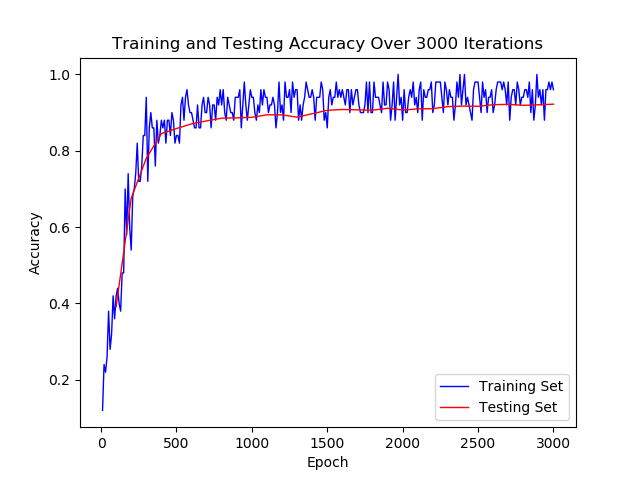

In [22]:
plt.figure(1)
plt.plot(np.linspace(TRAIN_PERIOD, NUM_EPOCHS, int(NUM_EPOCHS/TRAIN_PERIOD)),
         train_accuracy_hist, 'b-', linewidth = 1.0)
plt.plot(np.linspace(TEST_PERIOD, NUM_EPOCHS, int(NUM_EPOCHS/TEST_PERIOD)),
         test_accuracy_hist,'r-', linewidth = 1.0)
plt.title('Training and Testing Accuracy Over {} Iterations'.format(NUM_EPOCHS))
plt.legend(['Training Set', 'Testing Set'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### 3.2. Plot Loss Over Epochs

<IPython.core.display.Javascript object>


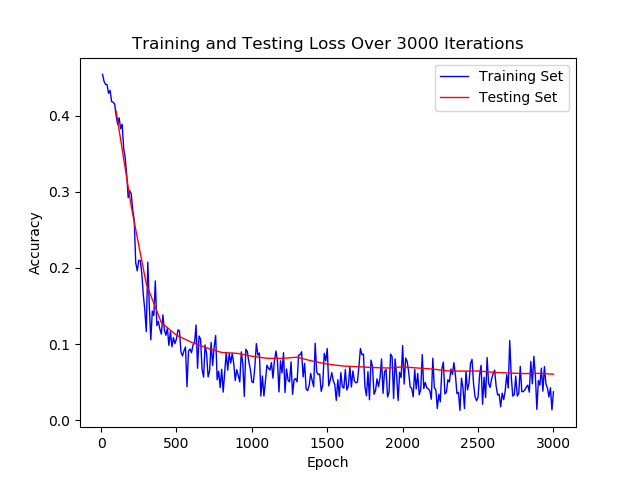

In [23]:
plt.figure(2)
plt.plot(np.linspace(TRAIN_PERIOD, NUM_EPOCHS, int(NUM_EPOCHS/TRAIN_PERIOD)),
         train_loss_hist, 'b-', linewidth = 1.0)
plt.plot(np.linspace(TEST_PERIOD, NUM_EPOCHS, int(NUM_EPOCHS/TEST_PERIOD)),
         test_loss_hist,'r-', linewidth = 1.0)
plt.title('Training and Testing Loss Over {} Iterations'.format(NUM_EPOCHS))
plt.legend(['Training Set', 'Testing Set'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### 3.3. Final Accuracy by Digits

In [24]:
for digit, accuracy in enumerate(test_accuracy_digit):
    print('Digit {} accuracy = {:.3f}%'.format(digit, accuracy*100.))

Digit 0 accuracy = 96.813%
Digit 1 accuracy = 96.442%
Digit 2 accuracy = 88.129%
Digit 3 accuracy = 88.676%
Digit 4 accuracy = 93.182%
Digit 5 accuracy = 88.621%
Digit 6 accuracy = 97.526%
Digit 7 accuracy = 91.271%
Digit 8 accuracy = 91.068%
Digit 9 accuracy = 89.958%
